In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

In [29]:
from BHDVCStf import BHDVCS

In [30]:
bhdvcs = BHDVCS()

In [53]:
data = pd.read_csv('dvcs_psuedo.csv')

# For Set 0

In [42]:
data = data.loc[(data['#Set'] == 0) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [43]:
def produceLHS(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    interference = data['F'] - data['dvcs'] - bh
    interference /= bhdvcs.Gamma
    interference *= data['QQ']
    interference *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    interference /= b
    return interference

In [44]:
def produceLHSerr(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    err = data['errF']
    err /= bhdvcs.Gamma
    err *= data['QQ']
    err *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    err /= b
    return err

In [45]:
def aoverb(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    return a/b

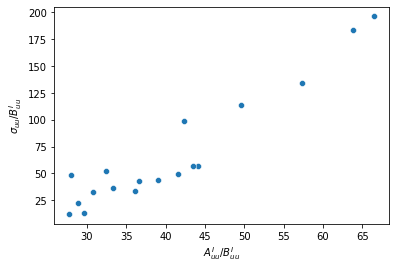

In [46]:
sns.scatterplot(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs))
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

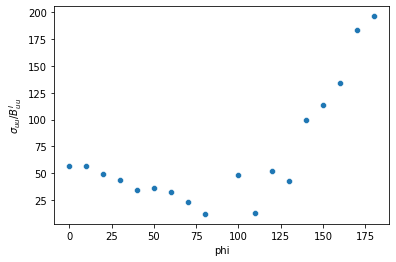

In [48]:
sns.scatterplot(x=data['phi_x'], y=produceLHS(data, bhdvcs))
plt.xlabel('phi')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

In [49]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
err = produceLHSerr(data, bhdvcs)

In [50]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.ABcon(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [51]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

### Fitted Compton Form Factors

In [15]:
cffs

array([ 16.20321612, -70.95512652])

In [16]:
np.diag(var)

array([ 12.7743163 , 337.41543006])

### True CFFs

In [17]:
data.loc[0, ['ReH', 'ReE']]

ReH    13.0554
ReE   -53.0554
Name: 0, dtype: float64

In [18]:
yhat = linear_curve_fit(X, *cffs)
yhatupper = linear_curve_fit(X, *(cffs + np.diag(var)))
yhatlower = linear_curve_fit(X, *(cffs - np.diag(var)))

In [19]:
yhatwtrue = linear_curve_fit(X, 13.0554, -53.0554)

### Central Values

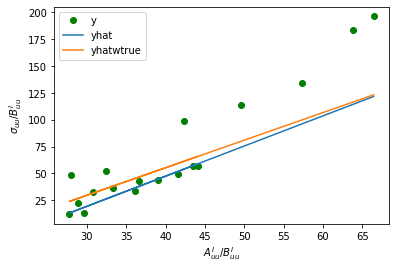

In [20]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Error

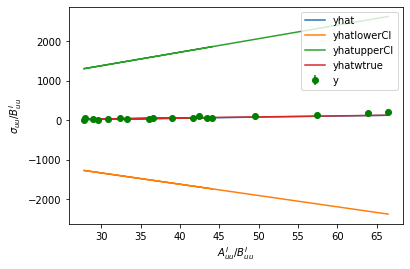

In [21]:
plt.errorbar(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), yerr=err, fmt='go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatlower, label='yhatlowerCI')
plt.plot(aoverb(data, bhdvcs), yhatupper, label='yhatupperCI')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Limits

In [22]:
high = data.copy()
high['F'] = data['F'] + data['errF']
low = data.copy()
low['F'] = data['F'] - data['errF']

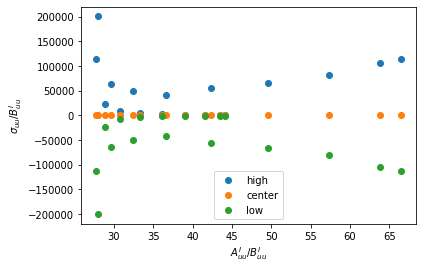

In [25]:
plt.scatter(x=aoverb(high, bhdvcs), y=produceLHS(high, bhdvcs), label='high')
plt.scatter(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs), label='center')
plt.scatter(x=aoverb(low, bhdvcs), y=produceLHS(low, bhdvcs), label='low')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## A/B vs phi

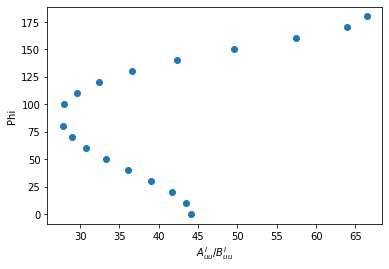

In [23]:
plt.scatter(aoverb(data, bhdvcs), data['phi_x'])
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('Phi')
plt.show()

# New Error

In [59]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
high = data.copy()
high['F'] = data['F'] + data['errF']
err = np.abs(produceLHS(high, bhdvcs) - y)

In [60]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

In [61]:
cffs

array([-4.14998417, 30.11224422])

$$\frac{g_1(b)}{1−G_1(b)} > \frac{g_2(b)}{1−G_2(b)}$$

In [ ]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

# Simultaneous

In [38]:
import BHDVCStf

In [59]:
import utilities

In [ ]:
def combined_function(data, ReH, ReE, ReHtilde)

In [78]:
data = pd.read_csv('dvcs_psuedo.csv')

In [79]:
data['F'] = produceLHS(data, bhdvcs)
data['errF'] = np.abs(produceLHSerr(data, bhdvcs))

In [80]:
data = utilities.DvcsData(data)

In [81]:
from tqdm import tqdm

In [85]:
def produceResults(data, numSets, numReplicas):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    for i in tqdm(range(numSets)):
        replicas = []
        seti = data.getSet(i) # DvcsData object of kinematic set i
        X = np.array(seti.XnoCFF) # the kinematics and all variables necessary to compute 
        sigma = seti.erry 
        pars = np.array([1, 1])
        for i in range(numReplicas):
            y = seti.sampleY()
            cff, cffcov = optimize.curve_fit(linear_curve_fit, X, y, pars, sigma, method='lm')
            replicas.append(cff)
        results.append(replicas)
    return np.array(results)

In [86]:
results = produceResults(data, 15, 100)

  0%|          | 0/15 [00:00<?, ?it/s]/Users/nick/Documents/ANN/Nick/BHDVCStf.py:67: RuntimeWarning: divide by zero encountered in true_divide
  self.xi = 1. * self.x * ( ( 1. + self.t / ( 2. * self.QQ ) ) / ( 2. - self.x + self.x * self.t / self.QQ ) ) # skewness parameter eq. (12b) dnote: there is a minus sign on the write up that shouldn't be there
/Users/nick/Documents/ANN/Nick/BHDVCStf.py:67: RuntimeWarning: invalid value encountered in true_divide
  self.xi = 1. * self.x * ( ( 1. + self.t / ( 2. * self.QQ ) ) / ( 2. - self.x + self.x * self.t / self.QQ ) ) # skewness parameter eq. (12b) dnote: there is a minus sign on the write up that shouldn't be there
/Users/nick/Documents/ANN/Nick/BHDVCStf.py:78: RuntimeWarning: divide by zero encountered in true_divide
  self.cth = -1. / tf.sqrt( 1. + self.gg ) * ( 1. + self.gg / 2. * ( 1. + self.t / self.QQ ) / ( 1. + self.x * self.t / self.QQ ) ) # This is tf.cos(theta) eq. (26)
/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack

In [87]:
results

array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       ...,

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]]])